In [0]:
!pip install pyspark

In [0]:
# import all required libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os
from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import StringIndexer, IndexToString
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
from sklearn.metrics import roc_curve, auc
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
# Create SparkSession
spark = SparkSession.builder.appName('Big_Data').getOrCreate()

In [0]:
# load the dataset, create sprk dataframe, and print schma
df = spark.read.csv('/FileStore/tables/train.csv',header = 'True',inferSchema='True')
print(df.limit(10).toPandas())
df.printSchema()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54

In [0]:
# check the null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



In [0]:
# drop cabin column
df = df.drop("Cabin")

In [0]:
df = df.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
df.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,Q,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Mrs


In [0]:
# replace inital with correct convention
df = df.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])
df.groupby('Initial').avg('Age').collect()

Out[8]: [Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [0]:
# fill null values in age column using avearge age
df = df.withColumn("Age",when((df["Initial"] == "Miss")   & (df["Age"].isNull()), 22).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Other")  & (df["Age"].isNull()), 46).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Master") & (df["Age"].isNull()), 5).otherwise( df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mr")     & (df["Age"].isNull()), 33).otherwise(df["Age"]))
df = df.withColumn("Age",when((df["Initial"] == "Mrs")    & (df["Age"].isNull()), 36).otherwise(df["Age"]))

In [0]:
# groupby embarked column
df.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [0]:
# Fill null values in embarked column and again check data have null
df = df.na.fill({"Embarked" : 'S'})
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



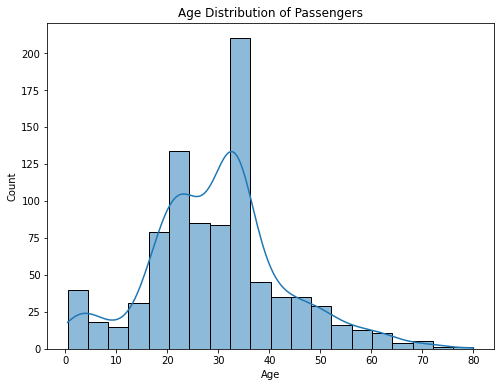

In [0]:
# Bar plot showing the count of passengers by sex
plt.figure(figsize=(8, 6))
sns.histplot(plot_df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Passengers')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

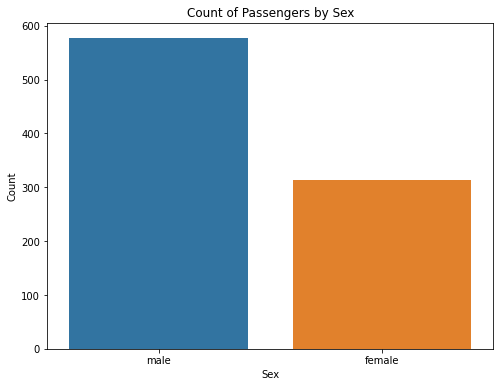

In [0]:
# Pie chart showing the distribution of passenger classes
plt.figure(figsize=(8, 6))
sns.countplot(x=plot_df['Sex'], data=plot_df)
plt.title('Count of Passengers by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

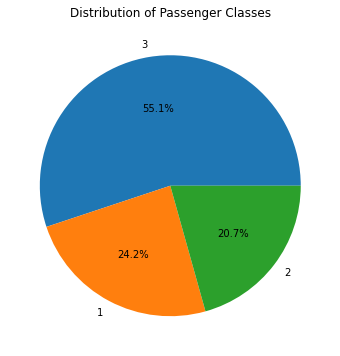

In [0]:
# Histogram showing the age distribution of passengers
plt.figure(figsize=(8, 6))
plot_df['Pclass'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Distribution of Passenger Classes')
plt.ylabel('')
plt.show()

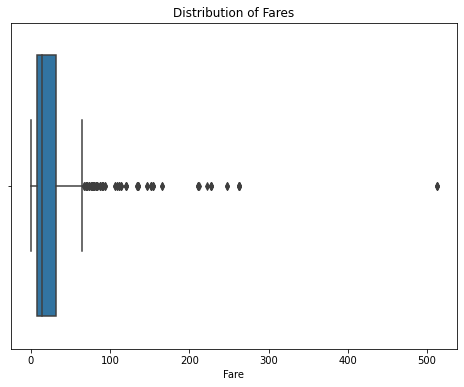

In [0]:
# Box plot showing the distribution of fares
plt.figure(figsize=(8, 6))
sns.boxplot(x='Fare', data=plot_df)
plt.title('Distribution of Fares')
plt.xlabel('Fare')
plt.show()


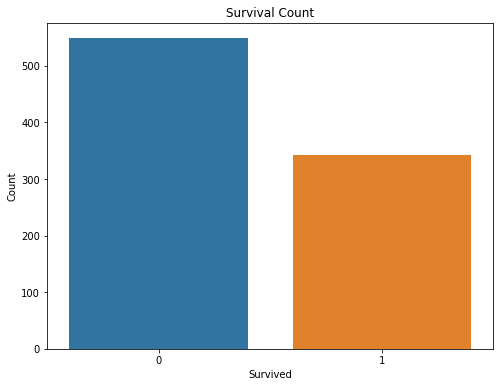

In [0]:
# Count plot showing the number of passengers who survived and who did not
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=plot_df)
plt.title('Survival Count')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()

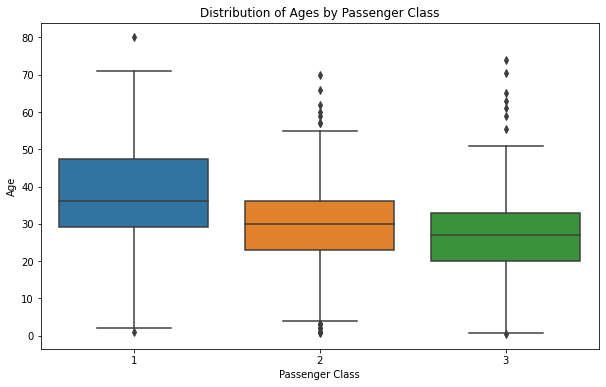

In [0]:
# Box plot showing the distribution of ages by passenger class
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=plot_df)
plt.title('Distribution of Ages by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.show()

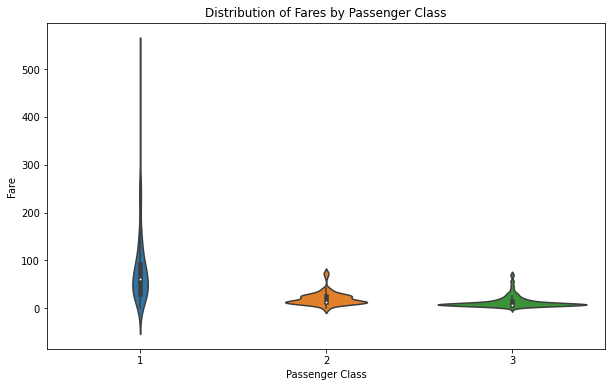

In [0]:
# Violin plot showing the distribution of fares by passenger class
plt.figure(figsize=(10, 6))
sns.violinplot(x='Pclass', y='Fare', data=plot_df)
plt.title('Distribution of Fares by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()

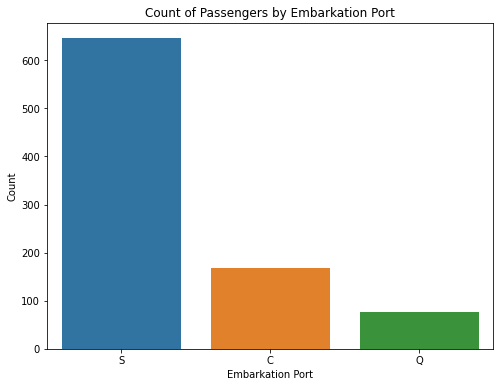

In [0]:
# Bar plot showing the count of passengers by embarkation port
plt.figure(figsize=(8, 6))
sns.countplot(x='Embarked', data=plot_df)
plt.title('Count of Passengers by Embarkation Port')
plt.xlabel('Embarkation Port')
plt.ylabel('Count')
plt.show()

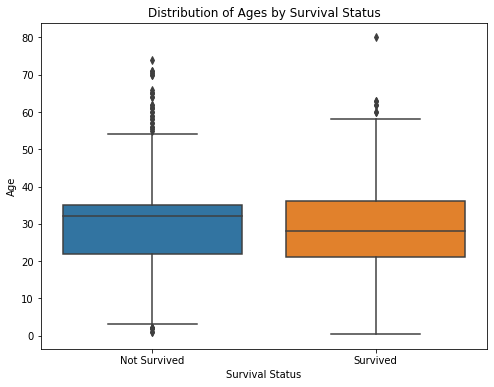

In [0]:
# Box plot showing the distribution of ages by survival status
plt.figure(figsize=(8, 6))
sns.boxplot(x='Survived', y='Age', data=plot_df)
plt.title('Distribution of Ages by Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Age')
plt.xticks([0, 1], ['Not Survived', 'Survived'])
plt.show()

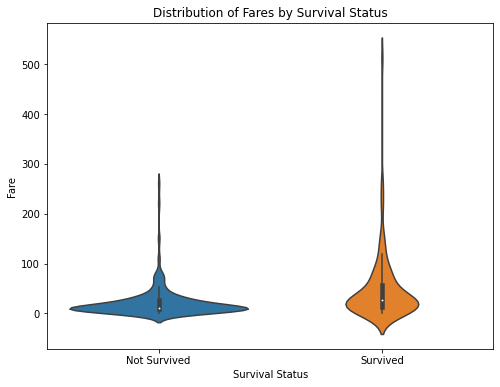

In [0]:
# Violin plot showing the distribution of fares by survival status
plt.figure(figsize=(8, 6))
sns.violinplot(x='Survived', y='Fare', data=plot_df)
plt.title('Distribution of Fares by Survival Status')
plt.xlabel('Survival Status')
plt.ylabel('Fare')
plt.xticks([0, 1], ['Not Survived', 'Survived'])
plt.show()

In [0]:
# feature engineering
df = df.withColumn("Family_Size",col('SibSp')+col('Parch'))
df = df.withColumn('Alone',lit(0)) 
df = df.withColumn("Alone",when(df["Family_Size"] == 0, 1).otherwise(df["Alone"]))
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)
df.limit(10).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,0,1.0,0.0,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0,1,0.0,0.0,0.0
5,6,0,3,"Moran, Mr. James",male,33.0,0,0,330877,8.4583,Q,Mr,0,1,0.0,2.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,Mr,0,1,0.0,0.0,0.0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,S,Master,4,0,0.0,0.0,3.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,S,Mrs,2,0,1.0,0.0,2.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,C,Mrs,1,0,1.0,1.0,2.0


In [0]:
# drop unused columns and convert to feature vectors
df = df.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")
feature = VectorAssembler(inputCols = df.columns[1:],outputCol="features")
feature_vector= feature.transform(df)
feature_vector.limit(10).toPandas()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."
3,1,1,35.0,1,0,53.1000,1,0,1.0,0.0,2.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 0.0, 1.0, 0.0..."
4,0,3,35.0,0,0,8.0500,0,1,0.0,0.0,0.0,"(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 1.0, 0.0, 0.0..."
5,0,3,33.0,0,0,8.4583,0,1,0.0,2.0,0.0,"(3.0, 33.0, 0.0, 0.0, 8.4583, 0.0, 1.0, 0.0, 2..."
6,0,1,54.0,0,0,51.8625,0,1,0.0,0.0,0.0,"(1.0, 54.0, 0.0, 0.0, 51.8625, 0.0, 1.0, 0.0, ..."
7,0,3,2.0,3,1,21.0750,4,0,0.0,0.0,3.0,"[3.0, 2.0, 3.0, 1.0, 21.075, 4.0, 0.0, 0.0, 0...."
8,1,3,27.0,0,2,11.1333,2,0,1.0,0.0,2.0,"[3.0, 27.0, 0.0, 2.0, 11.1333, 2.0, 0.0, 1.0, ..."
9,1,2,14.0,1,0,30.0708,1,0,1.0,1.0,2.0,"[2.0, 14.0, 1.0, 0.0, 30.0708, 1.0, 0.0, 1.0, ..."


In [0]:
# split the data into training and testing
new_df = feature_vector.select(['features','Survived'])
train,test = new_df.randomSplit([0.8,0.2])

In [0]:
# Logistic Regression
lr = LogisticRegression(labelCol="Survived")
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train)
model_predictions= model.transform(test)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))


Accuracy:  0.7796610169491526
Precision:  0.7785431040947952


In [0]:
# Evaluating ROC metric
sc =SparkContext.getOrCreate() 
results = model_predictions.select(['probability', 'Survived'])

results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.8471417281348788


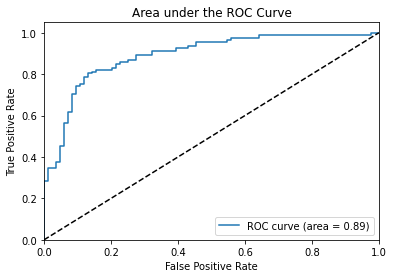

In [0]:
# Visualizing AUC metrics
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol='Survived')
paramGrid = ParamGridBuilder()\
                                .addGrid(rf.maxDepth, [5, 10, 20]) \
                                .addGrid(rf.maxBins, [20, 32, 50]) \
                                .addGrid(rf.numTrees, [20, 40, 60 ]) \
                                .addGrid(rf.impurity, ["gini", "entropy"]) \
                                .addGrid(rf.minInstancesPerNode, [1, 5, 10]) \
                                .build()


tvs = TrainValidationSplit( estimator=rf
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train)
model_predictions= model.transform(test)


print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8214285714285714
Precision:  0.8294773928361714


In [0]:
# Evaluating ROC metric
sc =SparkContext.getOrCreate()
results = model_predictions.select(['probability', 'Survived'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is :  0.9134778911564626


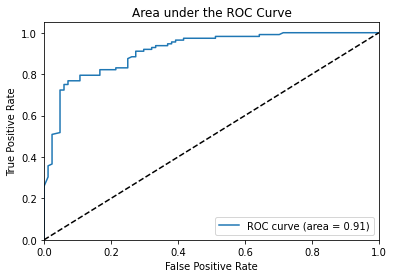

In [0]:
# Visualizing AUC metrics
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
# Gradient Boosting 
gbt = GBTClassifier(labelCol="Survived")
paramGrid = ParamGridBuilder()\
                            .addGrid(gbt.maxDepth, [5, 10, 20]) \
                            .addGrid(gbt.maxBins, [20, 32, 50]) \
                            .addGrid(gbt.maxIter, [10, 20, 30]) \
                            .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
                            .build()
    
tvs = TrainValidationSplit(estimator=gbt
                           , estimatorParamMaps=paramGrid
                            ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                            ,trainRatio=0.8)
model = tvs.fit(train)
model_predictions= model.transform(test)
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

In [0]:
# Evaluating ROC metric
sc =SparkContext.getOrCreate()
results = model_predictions.select(['probability', 'Survived'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is:  0.9134778911564626


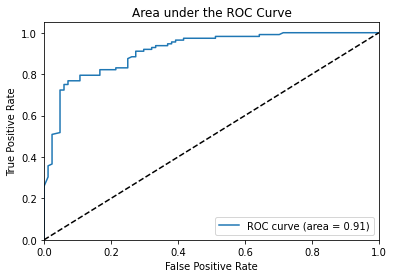

In [0]:
# Visualizing AUC metrics
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
#  Multilayer Perceptron Classifier
layers = [10, 10, 5, 2]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol='Survived', featuresCol='features', seed=56)
mlp_model = mlp.fit(train)
predictions = mlp_model.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol='Survived', predictionCol='prediction', metricName='accuracy')
print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(predictions))

Accuracy:  0.807909604519774
Precision:  0.8209076474280861


In [0]:
# Evaluating ROC metric
sc =SparkContext.getOrCreate()
results = predictions.select(['probability', 'Survived'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
metrics = metric(scoreAndLabels)
print("The ROC score is: ", metrics.areaUnderROC)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


The ROC score is:  0.8725632244467861


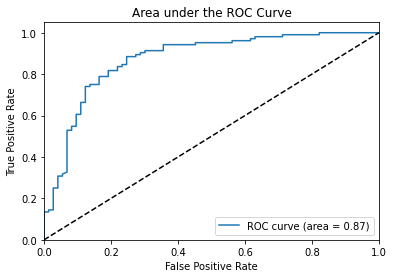

In [0]:
# Visualizing AUC metrics
fpr = dict()
tpr = dict()
roc_auc = dict()
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [0]:
# load the dataset, create sprk dataframe, and print schma
df=spark.read.csv('/FileStore/tables/movie_ratings_df.csv',inferSchema=True,header=True)
print(df.limit(10).toPandas())
df.printSchema()

   userId         title  rating
0     196  Kolya (1996)       3
1      63  Kolya (1996)       3
2     226  Kolya (1996)       5
3     154  Kolya (1996)       3
4     306  Kolya (1996)       5
5     296  Kolya (1996)       4
6      34  Kolya (1996)       5
7     271  Kolya (1996)       4
8     201  Kolya (1996)       4
9     209  Kolya (1996)       4
root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [0]:
# create new dataframe with transformed values
Indexer = StringIndexer(inputCol='title', outputCol='title_new')
model = Indexer.fit(df)
indexed = model.transform(df)
indexed.limit(10).toPandas()

,userId,title,rating,title_new
0,196,Kolya (1996),3,287.0
1,63,Kolya (1996),3,287.0
2,226,Kolya (1996),5,287.0
3,154,Kolya (1996),3,287.0
4,306,Kolya (1996),5,287.0
5,296,Kolya (1996),4,287.0
6,34,Kolya (1996),5,287.0
7,271,Kolya (1996),4,287.0
8,201,Kolya (1996),4,287.0
9,209,Kolya (1996),4,287.0


In [0]:
# split the data into training and testing
train, test = indexed.randomSplit([0.8,0.2])

In [0]:
#Training the recommender model and test
recommender=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='userId'
        ,itemCol='title_new'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

recommender_model=recommender.fit(train)
predicted=recommender_model.transform(test)
predicted.limit(10).toPandas()

,userId,title,rating,title_new,prediction
0,148,Cinderella (1950),3,243,3.472416
1,148,"Hunchback of Notre Dame, The (1996)",5,255,2.946409
2,148,Monty Python and the Holy Grail (1974),5,28,5.199703
3,148,Star Trek VI: The Undiscovered Country (1991),4,185,3.632651
4,148,Walkabout (1971),5,850,5.286775
5,148,Wallace & Gromit: The Best of Aardman Animatio...,5,488,5.364938
6,148,"Wrong Trousers, The (1993)",5,285,5.789182
7,463,"Adventures of Pinocchio, The (1996)",2,708,2.537280
8,463,Austin Powers: International Man of Mystery (1...,2,240,2.086302
9,463,Big Night (1996),2,159,3.625389


In [0]:
# Regression Evaluator to measure RMSE
evaluator=RegressionEvaluator(metricName='rmse',predictionCol='prediction',labelCol='rating')
rmse=evaluator.evaluate(predicted)
rmse

Out[18]: 1.0047419132513926

In [0]:
# check recommend top movies which user might like
uni_mov=indexed.select('title_new').distinct()
def top_recommend_movies(user_id,n):
    a = uni_mov.alias('a') 
    wat_mov=indexed.filter(indexed['userId'] == user_id).select('title_new')
    b=wat_mov.alias('b')
    tot_mov = a.join(b, a.title_new == b.title_new,how='left')
    remain_mov=tot_mov.where(col("b.title_new").isNull()).select(a.title_new).distinct()
    remain_mov=remain_mov.withColumn("userId",lit(int(user_id)))
    recommend=recommender_model.transform(remain_mov).orderBy('prediction',ascending=False).limit(n)
    mov_title = IndexToString(inputCol="title_new", outputCol="title",labels=model.labels)
    final_recommend=mov_title.transform(recommend)
    return final_recommend.show(n,False)

In [0]:
# check recommend movies for specific user
top_recommend_movies(148,10)

+---------+------+----------+-------------------------------------+
|title_new|userId|prediction|title                                |
+---------+------+----------+-------------------------------------+
|1283     |148   |11.144879 |Secret Agent, The (1996)             |
|1277     |148   |9.526763  |Mina Tannenbaum (1994)               |
|860      |148   |9.434957  |Naked (1993)                         |
|1092     |148   |9.145118  |American Buffalo (1996)              |
|731      |148   |8.60195   |Ace Ventura: When Nature Calls (1995)|
|845      |148   |8.59107   |Pillow Book, The (1995)              |
|1271     |148   |8.539201  |Hollow Reed (1996)                   |
|246      |148   |8.459322  |Crash (1996)                         |
|1143     |148   |8.242683  |Wonderland (1997)                    |
|1110     |148   |8.163273  |Wild Things (1998)                   |
+---------+------+----------+-------------------------------------+

